In [ ]:
! pip install -U efficientnet

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import efficientnet.keras as effnet

import tensorflow as tf
from tensorflow import keras

import os
import csv
from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# Loading the dataset
#cwd = os.getcwd()  # Get the current working directory (cwd)
#files = os.listdir(cwd)  # Get all the files in that directory
#print("Files in %r: %s" % (cwd, files))
#f = open("K:\histopathologic-cancer-detection\train.csv")

train_data = pd.read_csv(r"K:\histopathologic-cancer-detection\train_labels.csv")
train_data["filename"] = [item.id+".tif" for idx, item in train_data.iterrows()]
train_data["groundtruth"] = ["cancerous" if item.label==1 else "healthy" for idx, item in train_data.iterrows()]
train_data.head()

,id,label,filename,groundtruth
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,healthy
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,cancerous
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,healthy
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,healthy
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,healthy


In [ ]:
# Now I am going on to visualize the correlation between variables using a correlation heatmap
#plt.figure(figsize=(10,10))
#sns.heatmap(train_data.corr(), cmap="OrRd",annot=True, fmt=".1f")
#plt.title("Correlation between variables", size=15)
#plt.show();

In [ ]:
# The train_labels.csv dataset is split into 2 pieces, 80% for training and 20% for validation
training_sample_percentage = 0.8
training_sample_size = int(len(train_data)*training_sample_percentage)
validatin_sample_size = len(train_data)-training_sample_size
training_df = train_data.sample(n=training_sample_size)
validation_df = train_data[~train_data.index.isin(training_df.index)]

In [ ]:
training_batch_size = 64
validation_batch_size = 64
target_size = (96, 96)

# Data Augmentation Using Python and Keras
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            horizontal_flip = True,
            vertical_flip = True,
            zoom_range = 0.2,
            width_shift_range = 0.1,
            height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
            dataframe = training_df,
            x_col = "filename",
            y_col = "groundtruth",
            directory = (r"K:\histopathologic-cancer-detection\train"),
            target_size = target_size,
            batch_size = training_batch_size,
            shuffle = True,
            class_mode = "binary"
)
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
            dataframe = validation_df,
            x_col = "filename",
            y_col = "groundtruth",
            directory = (r"K:\histopathologic-cancer-detection\train"),
            target_size = target_size,
            batch_size = validation_batch_size,
            shuffle = False,
            class_mode = "binary")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
# Checking whether Data Augmentation has accidentally generated weird images
def plot_random_samples(generator):
    generator_size = len(generator)
    index=random.randint(0,generator_size-1)
    image,label = generator.__getitem__(index)
    
    sample_number = 10
    fig = plt.figure(figsize = (20,sample_number))
    for i in range(0,sample_number):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(image[i])
        if label[i]==0:
            ax.set_title("Cancerous cells")
        elif label[i]==1:
            ax.set_title("Healthy cells")
    plt.tight_layout()
    plt.show()
    

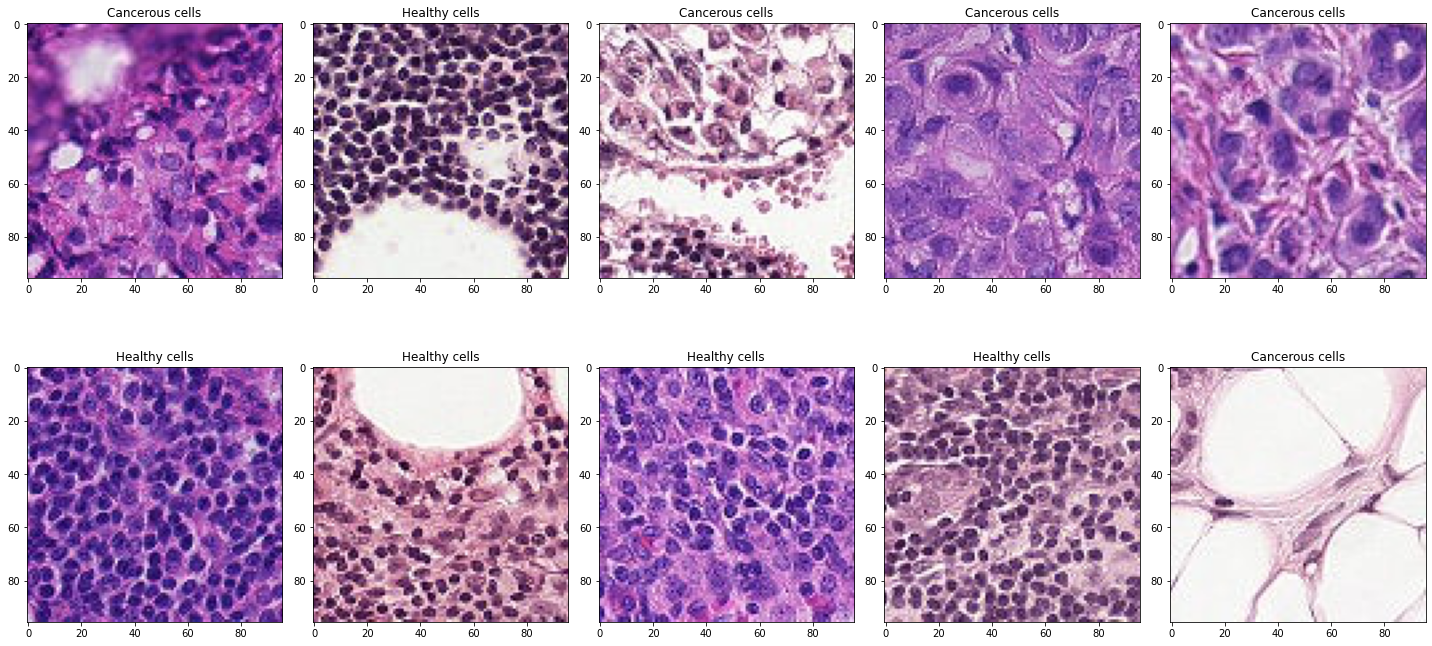

In [ ]:
plot_random_samples(validation_generator)

# VGG16

In [ ]:
vgg16_pretrained_layers = VGG16(weights='imagenet',include_top = False, input_shape = (96, 96, 3))
vgg16_pretrained_layers.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [ ]:
# Freezing all layers except the last 8
for layer in vgg16_pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in vgg16_pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022F2DEEFEE0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2DF08070> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2DF088E0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022F2D493D30> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2DF08EB0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2D4B2F10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022F2D4C9B80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2D4BE880> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2D4DEE20> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2D4E6F10> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022F2D517130> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2D508DC0> True
<keras.layers.convolutional.conv2d.Conv2D object 

In [ ]:
# creating model through addition on of pre-trained VGG16 in conjunction with bottle-neck layers which will end with a binary classification
dropout_dense_layer = 0.6

vgg16_model = Sequential()
vgg16_model.add(vgg16_pretrained_layers)
    
vgg16_model.add(GlobalAveragePooling2D())
vgg16_model.add(Dense(256, use_bias=False))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Activation('relu'))
vgg16_model.add(Dropout(dropout_dense_layer))

vgg16_model.add(Dense(1))
vgg16_model.add(Activation('sigmoid'))

In [ ]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131072    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
vgg16_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
#callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             #EarlyStopping(monitor='val_loss', patience=5),
             #ModelCheckpoint(filepath='vgg16_model', monitor='val_loss', save_best_only=True)]

#train_step_size = train_generator.n // train_generator.batch_size
#validation_step_size = validation_generator.n // validation_generator.batch_size

In [ ]:
vgg16_history = vgg16_model.fit_generator(train_generator,
          steps_per_epoch = 100,
          validation_data= validation_generator,
          epochs=10,
          verbose=1,
          shuffle=True)

C:\Users\dfd102\AppData\Local\Temp\ipykernel_12904\479426567.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_history = vgg16_model.fit_generator(train_generator,


Epoch 1/10
100/100 [==============================] - 725s 7s/step - loss: 0.5072 - accuracy: 0.7695 - val_loss: 0.4856 - val_accuracy: 0.7877
Epoch 2/10
100/100 [==============================] - 713s 7s/step - loss: 0.4300 - accuracy: 0.8164 - val_loss: 3.8536 - val_accuracy: 0.4186
Epoch 3/10
100/100 [==============================] - 721s 7s/step - loss: 0.4117 - accuracy: 0.8236 - val_loss: 0.5341 - val_accuracy: 0.7595
Epoch 4/10
100/100 [==============================] - 713s 7s/step - loss: 0.3828 - accuracy: 0.8392 - val_loss: 0.3710 - val_accuracy: 0.8436
Epoch 5/10
100/100 [==============================] - 722s 7s/step - loss: 0.3740 - accuracy: 0.8367 - val_loss: 0.3843 - val_accuracy: 0.8349
Epoch 6/10
100/100 [==============================] - 732s 7s/step - loss: 0.3605 - accuracy: 0.8522 - val_loss: 0.3425 - val_accuracy: 0.8604
Epoch 7/10
100/100 [==============================] - 718s 7s/step - loss: 0.3522 - accuracy: 0.8538 - val_loss: 0.3477 - val_accuracy: 0.8592

In [ ]:
# save the model weights
vgg16_model.save("vgg16_model.h5")

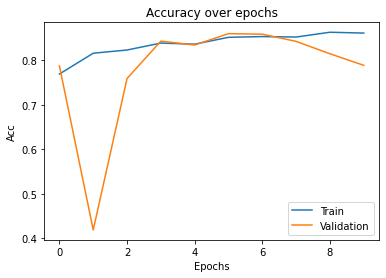

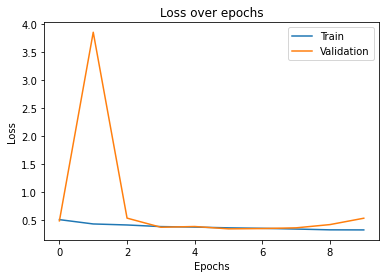

In [ ]:
# Plotting performance during training(accuracy and loss)
plt.plot(vgg16_history.history["accuracy"])
plt.plot(vgg16_history.history["val_accuracy"])
plt.title("Accuracy over epochs")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

plt.plot(vgg16_history.history["loss"])
plt.plot(vgg16_history.history["val_loss"])
plt.title("Loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

# ResNet 50

In [ ]:
ResNet50_pretrained_layers = ResNet50(weights='imagenet',include_top = False, input_shape = (96, 96, 3))
ResNet50_pretrained_layers.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 24, 24, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 24, 24, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 24, 24, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 24, 24, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 12, 12, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 12, 12, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 6, 6, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 6, 6, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 6, 6, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 6, 6, 1024)  4096        ['conv4_block2_3_conv[0][0]']    
 ization) 

 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 6, 6, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 6, 6, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 6, 6, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 3, 3, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 3, 3, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 3, 3, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_blo

In [ ]:
# Freezing all layers except the last 8
for layer in ResNet50_pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in ResNet50_pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022F2E0F1280> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000022F2D51BD30> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F2DE9FFA0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F30D29250> False
<keras.layers.core.activation.Activation object at 0x0000022F34B367F0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000022F34B4DA60> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022F30FD2340> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F30FE59A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F30FE53A0> False
<keras.layers.core.activation.Activation object at 0x0000022F31002C10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F31008F40> False
<keras.layers.normalization.batch_normalization.BatchNormalization obj

In [ ]:
# creating model through addition on of pre-trained ResNet50 in conjunction with bottle-neck layers which will end with a binary classification
dropout_dense_layer = 0.6

ResNet50_model = Sequential()
ResNet50_model.add(ResNet50_pretrained_layers)
    
ResNet50_model.add(GlobalAveragePooling2D())
ResNet50_model.add(Dense(256, use_bias=False))
ResNet50_model.add(BatchNormalization())
ResNet50_model.add(Activation('relu'))
ResNet50_model.add(Dropout(dropout_dense_layer))

ResNet50_model.add(Dense(1))
ResNet50_model.add(Activation('sigmoid'))

In [ ]:
ResNet50_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
ResNet50_history = ResNet50_model.fit_generator(train_generator,
          steps_per_epoch = 100,
          validation_data= validation_generator,
          epochs=10,
          verbose=1,
          shuffle=True)

C:\Users\dfd102\AppData\Local\Temp\ipykernel_12904\2479041898.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  ResNet50_history = ResNet50_model.fit_generator(train_generator,


Epoch 1/10
100/100 [==============================] - 439s 4s/step - loss: 0.6391 - accuracy: 0.6783 - val_loss: 1.9952 - val_accuracy: 0.4036
Epoch 2/10
100/100 [==============================] - 426s 4s/step - loss: 0.5740 - accuracy: 0.7220 - val_loss: 0.7251 - val_accuracy: 0.5205
Epoch 3/10
100/100 [==============================] - 432s 4s/step - loss: 0.5562 - accuracy: 0.7212 - val_loss: 0.6316 - val_accuracy: 0.6123
Epoch 4/10
100/100 [==============================] - 427s 4s/step - loss: 0.5413 - accuracy: 0.7337 - val_loss: 0.8714 - val_accuracy: 0.4830
Epoch 5/10
100/100 [==============================] - 435s 4s/step - loss: 0.5217 - accuracy: 0.7492 - val_loss: 1.2798 - val_accuracy: 0.4737
Epoch 6/10
100/100 [==============================] - 426s 4s/step - loss: 0.5243 - accuracy: 0.7452 - val_loss: 4.7816 - val_accuracy: 0.4039
Epoch 7/10
100/100 [==============================] - 431s 4s/step - loss: 0.5198 - accuracy: 0.7472 - val_loss: 0.8031 - val_accuracy: 0.5975

In [ ]:
# save the model weights
ResNet50_model.save("ResNet50_model.h5")

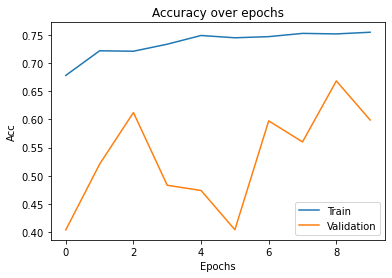

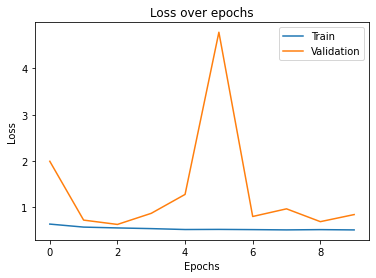

In [ ]:
# Plotting performance during training(accuracy and loss)
plt.plot(ResNet50_history.history["accuracy"])
plt.plot(ResNet50_history.history["val_accuracy"])
plt.title("Accuracy over epochs")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

plt.plot(ResNet50_history.history["loss"])
plt.plot(ResNet50_history.history["val_loss"])
plt.title("Loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

# Inception_V3

In [ ]:
InceptionV3_pretrained_layers = InceptionV3(weights='imagenet',include_top = False, input_shape = (96, 96, 3))
InceptionV3_pretrained_layers.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 activation_4 (Activation)      (None, 47, 47, 32)   0           ['batch_normalization_

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_13 (BatchN  (None, 9, 9, 32)    96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 9, 9, 64)     0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_11 (Activation)     (None, 9, 9, 64)     0           ['batch_normalization_9[0][0]']  
                                                                                                  
 activation_14 (Activation)     (None, 9, 9, 96)     0           ['batch_normalization_12[0][0]'] 
          

                                                                                                  
 conv2d_23 (Conv2D)             (None, 9, 9, 96)     55296       ['activation_26[0][0]']          
                                                                                                  
 batch_normalization_22 (BatchN  (None, 9, 9, 48)    144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_25 (BatchN  (None, 9, 9, 96)    288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 9, 9, 48)     0           ['batch_normalization_22[0][0]'] 
          

 conv2d_34 (Conv2D)             (None, 4, 4, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 4, 4, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 4, 4, 128)    0           ['batch_normalization_36[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 4, 4, 128)    114688      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 128)   384         ['conv2d_35[0][0]']              
 ormalizat

 activation_48 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_46[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_48[0][0]']          
                                                                                                  
 batch_normalization_47 (BatchN  (None, 4, 4, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_49 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 conv2d_41 (Conv2D)             (None, 4, 4, 160)    122880      ['mixed4[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_59 (Activation)     (None, 4, 4, 160)    0           ['batch_normalization_57[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 4, 4, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 4, 4, 160)    179200      ['activation_59[0][0]']          
                                                                                                  
 batch_normalization_53 (BatchN  (None, 4, 4, 160)   480         ['conv2d_51[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_66 (Conv2D)             (None, 4, 4, 192)    258048      ['activation_69[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 4, 4, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_68 (BatchN  (None, 4, 4, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_63[0][0]'] 
          

                                                                                                  
 batch_normalization_76 (BatchN  (None, 4, 4, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_74 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 activation_78 (Activation)     (None, 4, 4, 192)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 1, 1, 320)    552960      ['activation_74[0][0]']          
                                                                                                  
 conv2d_75

 activation_86 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 activation_87 (Activation)     (None, 1, 1, 384)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 batch_normalization_86 (BatchN  (None, 1, 1, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_80 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 mixed9_0 (Concatenate)         (None, 1, 1, 768)    0           ['activation_82[0][0]',          
          

                                                                                                  
 activation_89 (Activation)     (None, 1, 1, 320)    0           ['batch_normalization_87[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 1, 1, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 1, 1, 768)    0           ['activation_95[0][0]',          
                                                                  'activation_96[0][0]']          
                                                                                                  
 activation_97 (Activation)     (None, 1, 1, 192)    0           ['batch_normalization_95[0][0]'] 
          

In [ ]:
# Freezing all layers except the last 8
for layer in InceptionV3_pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in InceptionV3_pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022F42A30B80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F41862DF0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F42A301C0> False
<keras.layers.core.activation.Activation object at 0x0000022F42A220D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F42A799D0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F42A67190> False
<keras.layers.core.activation.Activation object at 0x0000022F42A67BE0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F42A89520> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F42A9EAF0> False
<keras.layers.core.activation.Activation object at 0x0000022F42A89940> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000022F42B0D0D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F42A79A

<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F4505FDF0> False
<keras.layers.core.activation.Activation object at 0x0000022F44FB43D0> False
<keras.layers.core.activation.Activation object at 0x0000022F42D97A60> False
<keras.layers.core.activation.Activation object at 0x0000022F44FD03D0> False
<keras.layers.core.activation.Activation object at 0x0000022F4508B2E0> False
<keras.layers.merging.concatenate.Concatenate object at 0x0000022F4508B4F0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F450255B0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F450A3070> False
<keras.layers.core.activation.Activation object at 0x0000022F4509BB50> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F450B2790> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F42B712E0> False
<keras.layers.core.activation.Activation object at 0x0000022F450D894

In [ ]:
# creating model through addition on of pre-trained InceptionV3 in conjunction with bottle-neck layers which will end with a binary classification
dropout_dense_layer = 0.6

InceptionV3_model = Sequential()
InceptionV3_model.add(InceptionV3_pretrained_layers)
    
InceptionV3_model.add(GlobalAveragePooling2D())
InceptionV3_model.add(Dense(256, use_bias=False))
InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Activation('relu'))
InceptionV3_model.add(Dropout(dropout_dense_layer))

InceptionV3_model.add(Dense(1))
InceptionV3_model.add(Activation('sigmoid'))

In [ ]:
InceptionV3_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
InceptionV3_history = InceptionV3_model.fit_generator(train_generator,
          steps_per_epoch = 100,
          validation_data= validation_generator,
          epochs=10,
          verbose=1,
          shuffle=True)

C:\Users\dfd102\AppData\Local\Temp\ipykernel_12904\3267012599.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  InceptionV3_history = InceptionV3_model.fit_generator(train_generator,


Epoch 1/10
100/100 [==============================] - 204s 2s/step - loss: 0.6281 - accuracy: 0.7189 - val_loss: 0.4828 - val_accuracy: 0.7843
Epoch 2/10
100/100 [==============================] - 199s 2s/step - loss: 0.5371 - accuracy: 0.7528 - val_loss: 0.4573 - val_accuracy: 0.7885
Epoch 3/10
100/100 [==============================] - 202s 2s/step - loss: 0.5020 - accuracy: 0.7652 - val_loss: 0.4268 - val_accuracy: 0.8072
Epoch 4/10
100/100 [==============================] - 206s 2s/step - loss: 0.5119 - accuracy: 0.7638 - val_loss: 0.4591 - val_accuracy: 0.7871
Epoch 5/10
100/100 [==============================] - 216s 2s/step - loss: 0.4892 - accuracy: 0.7719 - val_loss: 0.4297 - val_accuracy: 0.8053
Epoch 6/10
100/100 [==============================] - 196s 2s/step - loss: 0.4741 - accuracy: 0.7791 - val_loss: 0.4212 - val_accuracy: 0.8072
Epoch 7/10
100/100 [==============================] - 194s 2s/step - loss: 0.4713 - accuracy: 0.7795 - val_loss: 0.4187 - val_accuracy: 0.8121

In [ ]:
# save the model weights
InceptionV3_model.save("InceptionV3_model.h5")

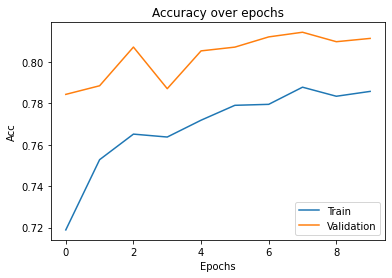

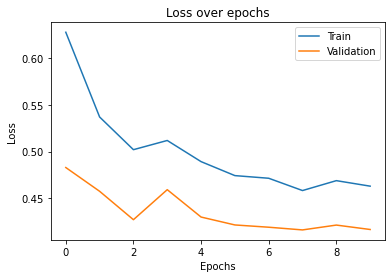

In [ ]:
# Plotting performance during training(accuracy and loss)
plt.plot(InceptionV3_history.history["accuracy"])
plt.plot(InceptionV3_history.history["val_accuracy"])
plt.title("Accuracy over epochs")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

plt.plot(InceptionV3_history.history["loss"])
plt.plot(InceptionV3_history.history["val_loss"])
plt.title("Loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

# EfficientNet

In [ ]:
EfficientNetB7_pretrained_layers = effnet.EfficientNetB7(weights='imagenet',include_top = False, input_shape = (96, 96, 3))
EfficientNetB7_pretrained_layers.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 64)   1728        ['input_4[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 48, 48, 64)   0           ['stem_bn[0][0]']                
                                                                                    

                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1c_se_reduce[0][0]']      
                                                                                                  
 block1c_se_excite (Multiply)   (None, 48, 48, 32)   0           ['block1c_activation[0][0]',     
                                                                  'block1c_se_expand[0][0]']      
                                                                                                  
 block1c_project_conv (Conv2D)  (None, 48, 48, 32)   1024        ['block1c_se_excite[0][0]']      
                                                                                                  
 block1c_project_bn (BatchNorma  (None, 48, 48, 32)  128         ['block1c_project_conv[0][0]']   
 lization)                                                                                        
          

 block2b_expand_bn (BatchNormal  (None, 24, 24, 288)  1152       ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 24, 24, 288)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 24, 24, 288)  2592       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 24, 24, 288)  1152       ['block2b_dwconv[0][0]']         
 )        

                                                                                                  
 block2d_dwconv (DepthwiseConv2  (None, 24, 24, 288)  2592       ['block2d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2d_bn (BatchNormalization  (None, 24, 24, 288)  1152       ['block2d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2d_activation (Activation  (None, 24, 24, 288)  0          ['block2d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2d_s

 )                                                                                                
                                                                                                  
 block2f_activation (Activation  (None, 24, 24, 288)  0          ['block2f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2f_se_squeeze (GlobalAver  (None, 288)         0           ['block2f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2f_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block2f_se_squeeze[0][0]']     
                                                                                                  
 block2f_s

 block3a_se_squeeze (GlobalAver  (None, 288)         0           ['block3a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 12, 12, 288)  0           ['block3a_activation[0][0]',     
          

                                                                  'block3c_se_expand[0][0]']      
                                                                                                  
 block3c_project_conv (Conv2D)  (None, 12, 12, 80)   38400       ['block3c_se_excite[0][0]']      
                                                                                                  
 block3c_project_bn (BatchNorma  (None, 12, 12, 80)  320         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 12, 12, 80)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 12, 12, 80)   0           ['block3c_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block3e_drop (FixedDropout)    (None, 12, 12, 80)   0           ['block3e_project_bn[0][0]']     
                                                                                                  
 block3e_add (Add)              (None, 12, 12, 80)   0           ['block3e_drop[0][0]',           
                                                                  'block3d_add[0][0]']            
                                                                                                  
 block3f_expand_conv (Conv2D)   (None, 12, 12, 480)  38400       ['block3e_add[0][0]']            
                                                                                                  
 block3f_expand_bn (BatchNormal  (None, 12, 12, 480)  1920       ['block3f_expand_conv[0][0]']    
 ization) 

                                                                  'block3f_add[0][0]']            
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 12, 12, 480)  38400       ['block3g_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 12, 12, 480)  1920       ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 12, 12, 480)  0          ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_d

 block4c_dwconv (DepthwiseConv2  (None, 6, 6, 960)   8640        ['block4c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 6, 6, 960)   3840        ['block4c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 6, 6, 960)   0           ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 960)         0           ['block4c_activation[0][0]']     
 agePoolin

                                                                                                  
 block4e_activation (Activation  (None, 6, 6, 960)   0           ['block4e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4e_se_squeeze (GlobalAver  (None, 960)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4e_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block4g_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4g_se_squeeze[0][0]']     
                                                                                                  
 block4g_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 6, 6, 960)    0           ['block4g_activation[0][0]',     
                                                                  'block4g_se_expand[0][0]']      
          

                                                                                                  
 block4i_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4i_se_reduce[0][0]']      
                                                                                                  
 block4i_se_excite (Multiply)   (None, 6, 6, 960)    0           ['block4i_activation[0][0]',     
                                                                  'block4i_se_expand[0][0]']      
                                                                                                  
 block4i_project_conv (Conv2D)  (None, 6, 6, 160)    153600      ['block4i_se_excite[0][0]']      
                                                                                                  
 block4i_project_bn (BatchNorma  (None, 6, 6, 160)   640         ['block4i_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block5a_project_conv (Conv2D)  (None, 6, 6, 224)    215040      ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 6, 6, 224)   896         ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 6, 6, 1344)   301056      ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 6, 6, 1344)  5376        ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5d_expand_conv (Conv2D)   (None, 6, 6, 1344)   301056      ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 6, 6, 1344)  5376        ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 6, 6, 1344)  0           ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 6, 6, 1344)  33600       ['block5d_expand_activation[0][0]
 D)       

                                                                                                  
 block5f_expand_activation (Act  (None, 6, 6, 1344)  0           ['block5f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5f_dwconv (DepthwiseConv2  (None, 6, 6, 1344)  33600       ['block5f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5f_bn (BatchNormalization  (None, 6, 6, 1344)  5376        ['block5f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5f_a

 D)                                                              ']                               
                                                                                                  
 block5h_bn (BatchNormalization  (None, 6, 6, 1344)  5376        ['block5h_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5h_activation (Activation  (None, 6, 6, 1344)  0           ['block5h_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5h_se_squeeze (GlobalAver  (None, 1344)        0           ['block5h_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5j_activation (Activation  (None, 6, 6, 1344)  0           ['block5j_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5j_se_squeeze (GlobalAver  (None, 1344)        0           ['block5j_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5j_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5j_se_squeeze[0][0]']     
                                                                                                  
 block5j_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5j_se_reshape[0][0]']     
                                                                                                  
 block5j_s

 block6b_se_expand (Conv2D)     (None, 1, 1, 2304)   223488      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 3, 3, 2304)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 3, 3, 384)    884736      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 3, 3, 384)   1536        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_d

 block6d_project_conv (Conv2D)  (None, 3, 3, 384)    884736      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 3, 3, 384)   1536        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (FixedDropout)    (None, 3, 3, 384)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 3, 3, 384)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block6e_e

 block6f_drop (FixedDropout)    (None, 3, 3, 384)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 3, 3, 384)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 3, 3, 2304)   884736      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 3, 3, 2304)  9216        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6g_e

 block6i_expand_conv (Conv2D)   (None, 3, 3, 2304)   884736      ['block6h_add[0][0]']            
                                                                                                  
 block6i_expand_bn (BatchNormal  (None, 3, 3, 2304)  9216        ['block6i_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6i_expand_activation (Act  (None, 3, 3, 2304)  0           ['block6i_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6i_dwconv (DepthwiseConv2  (None, 3, 3, 2304)  57600       ['block6i_expand_activation[0][0]
 D)                                                              ']                               
          

 block6k_expand_activation (Act  (None, 3, 3, 2304)  0           ['block6k_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6k_dwconv (DepthwiseConv2  (None, 3, 3, 2304)  57600       ['block6k_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6k_bn (BatchNormalization  (None, 3, 3, 2304)  9216        ['block6k_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6k_activation (Activation  (None, 3, 3, 2304)  0           ['block6k_bn[0][0]']             
 )        

                                                                                                  
 block6m_bn (BatchNormalization  (None, 3, 3, 2304)  9216        ['block6m_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6m_activation (Activation  (None, 3, 3, 2304)  0           ['block6m_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6m_se_squeeze (GlobalAver  (None, 2304)        0           ['block6m_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6m_s

 block7b_se_reshape (Reshape)   (None, 1, 1, 3840)   0           ['block7b_se_squeeze[0][0]']     
                                                                                                  
 block7b_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7b_se_reshape[0][0]']     
                                                                                                  
 block7b_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7b_se_reduce[0][0]']      
                                                                                                  
 block7b_se_excite (Multiply)   (None, 3, 3, 3840)   0           ['block7b_activation[0][0]',     
                                                                  'block7b_se_expand[0][0]']      
                                                                                                  
 block7b_project_conv (Conv2D)  (None, 3, 3, 640)    2457600     ['block7b_se_excite[0][0]']      
          

                                                                                                  
 block7d_se_excite (Multiply)   (None, 3, 3, 3840)   0           ['block7d_activation[0][0]',     
                                                                  'block7d_se_expand[0][0]']      
                                                                                                  
 block7d_project_conv (Conv2D)  (None, 3, 3, 640)    2457600     ['block7d_se_excite[0][0]']      
                                                                                                  
 block7d_project_bn (BatchNorma  (None, 3, 3, 640)   2560        ['block7d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7d_drop (FixedDropout)    (None, 3, 3, 640)    0           ['block7d_project_bn[0][0]']     
          

In [ ]:
# Freezing all layers except the last 8
for layer in EfficientNetB7_pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in EfficientNetB7_pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000022F54F2FD60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F45303D30> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F45303CD0> False
<keras.layers.core.activation.Activation object at 0x0000022F558EA9D0> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000022F557EF7C0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F557BAF70> False
<keras.layers.core.activation.Activation object at 0x0000022F557D6460> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022F557D69A0> False
<keras.layers.reshaping.reshape.Reshape object at 0x0000022F557E6490> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F53194880> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F452D5070> False
<keras.layers.merging.multiply.Multiply object at 0x00

<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5BD907F0> False
<keras.layers.merging.multiply.Multiply object at 0x0000022F5BD6BD90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F55B6C3A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5BCFEEB0> False
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x0000022F53079AF0> False
<keras.layers.merging.add.Add object at 0x0000022F5BD5A0D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F530754C0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5BD43BE0> False
<keras.layers.core.activation.Activation object at 0x0000022F53075D90> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000022F5BD1A670> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5BDA9490> False
<keras.layers.core.activation.Activation object at 

<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5C070E80> False
<keras.layers.merging.multiply.Multiply object at 0x0000022F5BF593A0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5C0FA280> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5C116C40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5C10FFD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5C10FBB0> False
<keras.layers.core.activation.Activation object at 0x0000022F5C145A60> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000022F5C145850> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5C14ACA0> False
<keras.layers.core.activation.Activation object at 0x0000022F5C1456D0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022F5C13EC40> False
<keras.layers.reshaping.

<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5E6FA1F0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5E6D63A0> False
<keras.layers.core.activation.Activation object at 0x0000022F5E718D60> False
<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000022F5E718FD0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5E72B790> False
<keras.layers.core.activation.Activation object at 0x0000022F5E70D070> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022F5E6FAD00> False
<keras.layers.reshaping.reshape.Reshape object at 0x0000022F5E6CEF40> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5E6ECCD0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5E645DC0> False
<keras.layers.merging.multiply.Multiply object at 0x0000022F5E65A9A0> False
<keras.layers.convolutional.conv2d.Conv2D object at

<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5F64E3A0> False
<keras.layers.core.activation.Activation object at 0x0000022F5F39AB80> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022F5F646E20> False
<keras.layers.reshaping.reshape.Reshape object at 0x0000022F5F3920D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5F392BE0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5F2DBEB0> False
<keras.layers.merging.multiply.Multiply object at 0x0000022F5EBAC910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5F658CA0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5F2EE4C0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F5F6586A0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F5F2EE430> False
<keras.layers.core.activation.Activation obj

<keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000022F615BD0D0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F615F2CD0> False
<keras.layers.core.activation.Activation object at 0x0000022F615FCA00> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x0000022F615E2F70> False
<keras.layers.reshaping.reshape.Reshape object at 0x0000022F615DD310> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F615EB520> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F615A79A0> False
<keras.layers.merging.multiply.Multiply object at 0x0000022F615C31C0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000022F60F43730> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000022F61590850> False
<efficientnet.model.get_dropout.<locals>.FixedDropout object at 0x0000022F615FC790> False
<keras.layers.merging.add.Add object a

In [ ]:
# creating model through addition on of pre-trained InceptionV3 in conjunction with bottle-neck layers which will end with a binary classification
dropout_dense_layer = 0.6

EfficientNetB7_model = Sequential()
EfficientNetB7_model.add(EfficientNetB7_pretrained_layers)
    
EfficientNetB7_model.add(GlobalAveragePooling2D())
EfficientNetB7_model.add(Dense(256, use_bias=False))
EfficientNetB7_model.add(BatchNormalization())
EfficientNetB7_model.add(Activation('relu'))
EfficientNetB7_model.add(Dropout(dropout_dense_layer))

EfficientNetB7_model.add(Dense(1))
EfficientNetB7_model.add(Activation('sigmoid'))

In [ ]:
EfficientNetB7_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
EfficientNetB7_history = EfficientNetB7_model.fit_generator(train_generator,
          steps_per_epoch = 100,
          validation_data= validation_generator,
          epochs=10,
          verbose=1,
          shuffle=True)

C:\Users\dfd102\AppData\Local\Temp\ipykernel_12904\934143088.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  EfficientNetB7_history = EfficientNetB7_model.fit_generator(train_generator,


Epoch 1/10
100/100 [==============================] - 1473s 15s/step - loss: 0.6983 - accuracy: 0.6411 - val_loss: 0.5204 - val_accuracy: 0.7402
Epoch 2/10
100/100 [==============================] - 1463s 15s/step - loss: 0.5926 - accuracy: 0.7120 - val_loss: 0.5158 - val_accuracy: 0.7394
Epoch 3/10
100/100 [==============================] - 1489s 15s/step - loss: 0.5510 - accuracy: 0.7359 - val_loss: 0.4615 - val_accuracy: 0.7740
Epoch 4/10
100/100 [==============================] - 1494s 15s/step - loss: 0.5182 - accuracy: 0.7475 - val_loss: 0.4384 - val_accuracy: 0.7940
Epoch 5/10
100/100 [==============================] - 1466s 15s/step - loss: 0.5070 - accuracy: 0.7527 - val_loss: 0.4769 - val_accuracy: 0.7707
Epoch 6/10
100/100 [==============================] - 1448s 15s/step - loss: 0.5109 - accuracy: 0.7536 - val_loss: 0.4210 - val_accuracy: 0.8032
Epoch 7/10
100/100 [==============================] - 1457s 15s/step - loss: 0.4787 - accuracy: 0.7766 - val_loss: 0.5666 - val_ac

In [ ]:
# save the model weights
EfficientNetB7_model.save("EfficientNetB7_model.h5")

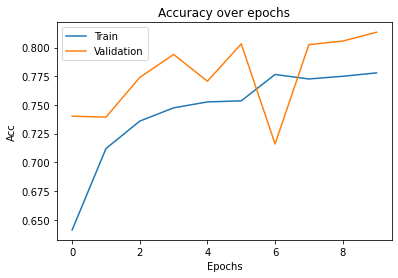

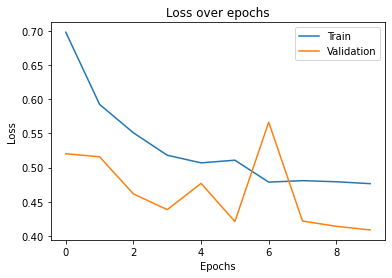

In [ ]:
# Plotting performance during training(accuracy and loss)
plt.plot(EfficientNetB7_history.history["accuracy"])
plt.plot(EfficientNetB7_history.history["val_accuracy"])
plt.title("Accuracy over epochs")
plt.ylabel("Acc")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

plt.plot(EfficientNetB7_history.history["loss"])
plt.plot(EfficientNetB7_history.history["val_loss"])
plt.title("Loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="best")
plt.show()

# Testing

In [ ]:
test_data = pd.read_csv(r"K:\histopathologic-cancer-detection\sample_submission.csv")
test_data.head()
test_datagen = ImageDataGenerator(
            rescale = 1./255.
            #rotation_range = 40,
            #horizontal_flip = True,
            #vertical_flip = True,
            #zoom_range = 0.2,
            #width_shift_range = 0.1,
           # height_shift_range = 0.1
)
test_generator = test_datagen.flow_from_dataframe(
            dataframe = test_data,
            x_col = "filename",
            dataframe.get("x_col", default = value_if_no_column),
            y_col = None,
            directory = (r"K:\histopathologic-cancer-detection\test"),
            target_size = target_size,
            batch_size = 1,
            shuffle = False,
            class_mode = "binary"
)

In [ ]:
test_data.info()

In [ ]:
pred=model.predict_generator(test_generator,verbose=1)